In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as F
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

data_dir = './dataset/'
files_train = [f'train_image_data_{fid}.parquet' for fid in range(1)]

HEIGHT = 137
WIDTH = 236

In [6]:
df_train = pd.read_csv(os.path.join(data_dir, f'train.csv'))

In [7]:
def read_data(files):
    tmp = []
    for f in files:
        F = os.path.join(data_dir, f)
        data = pd.read_parquet(F)
        tmp.append(data)
    tmp = pd.concat(tmp)

    data = tmp.iloc[:, 1:].values
    return data

# train data
data_train = read_data(files_train)

In [8]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [17]:
class BengaliDataset(Dataset):
    def __init__(self, csv, data, idx, split, mode, image_size, transform=None):

        self.csv = csv.reset_index()
        self.data = data
        self.idx = np.asarray(idx)
        self.split = split
        self.mode = mode
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return self.idx.shape[0]

    def __getitem__(self, index):
        index = self.idx[index]
        this_img_id = self.csv.iloc[index].image_id
        
        image = self.data[index].reshape(HEIGHT, WIDTH)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        
#         print(np.shape(image))
#         print(np.max(image))
        image = np.uint8(image)
        
        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image /= 255
        image = image[np.newaxis, :, :]
#         image = np.repeat(image, 3, 0)  # 1ch to 3ch

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            label_1 = self.csv.iloc[index].grapheme_root
            label_2 = self.csv.iloc[index].vowel_diacritic
            label_3 = self.csv.iloc[index].consonant_diacritic
            label = [label_1, label_2, label_3]
            return torch.tensor(image), torch.tensor(label)

In [13]:
def plot_imgs(dataset_show):
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range(2):
        f, axarr = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(dataset_show))
            img, label = dataset_show[idx]
            axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
            axarr[p].set_title(idx)

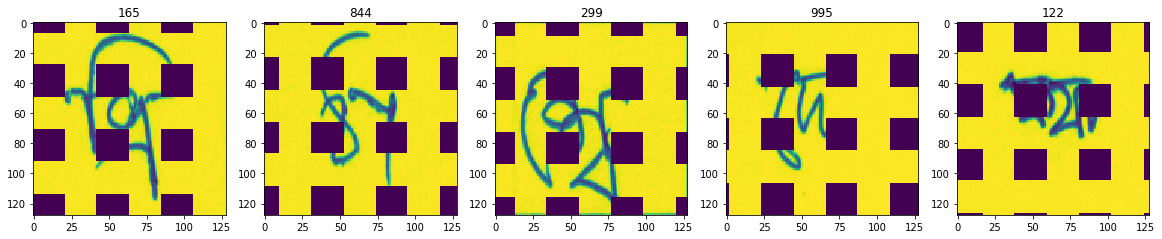

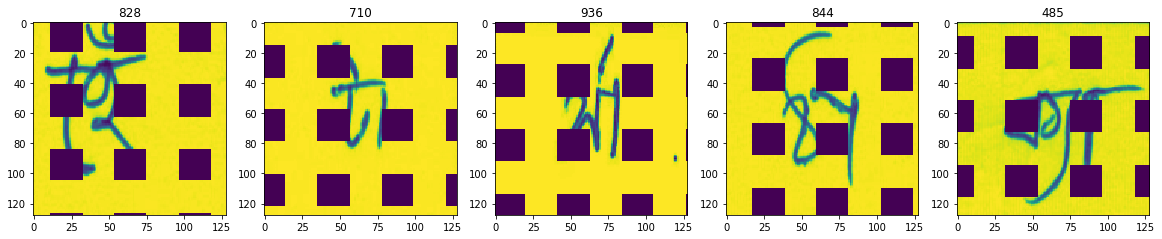

In [18]:
transforms_train = albumentations.Compose([
    GridMask(num_grid=3, p=1),
])

df_show = df_train.iloc[:1000]
dataset_show = BengaliDataset(df_show, data_train, list(range(df_show.shape[0])), 'train', 'train', 128, transform=transforms_train)
plot_imgs(dataset_show)